<a href="https://colab.research.google.com/github/ArbivIdan/CarAccident/blob/main/notebook868fa996da.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import cv2
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import MaxPool2D, Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
DATASET_ROOT_FOLDER_PATH = '/content/drive/MyDrive/CarAccidentData/data'
TRAIN_SRC_FOLDER_PATH = '/content/drive/MyDrive/CarAccidentData/data/train'
TEST_SRC_FOLDER_PATH = '/content/drive/MyDrive/CarAccidentData/data/test'
VALIDATION_SRC_FOLDER_PATH = '/content/drive/MyDrive/CarAccidentData/data/val'
IMAGE_EXAMPLE_PATH = "/content/drive/MyDrive/CarAccidentData/data/train/Non Accident/5_17.jpg"
IMAGE_LIST_EXAMPLE = ["5_10.jpg" , "test10_2.jpg", "test11_10.jpg", "test3_22.jpg", "test4_17.jpg", "test16_3.jpg", "test17_1.jpg", "test20_1.jpg"]
IMAGE_EXAMPLE_FOLDER_PATH = f"/content/drive/MyDrive/CarAccidentData/data/train/Non Accident"


# Connect Google Drive the Google Collab

In [2]:
from google.colab import drive
drive.mount('/content/drive')
# read me
# Access the uploaded folder
import os
os.chdir(DATASET_ROOT_FOLDER_PATH)

Mounted at /content/drive


# Define Hyperparameters

In [3]:
batch_size = 100
img_height = 250
img_width = 250
NUM_OF_EPOCHS = 50

# Setting up our Data  
Before we begin with creating and training our model, we will first set the size of the batches for our training, as well as the image height and width to set for our model

The dataset that we are using has 3 different folders, and each of these have 2 folders within them having a folder for accident images and non accident images. Do look and scroll through them to verify and see the structure.  
In order to get our:  
1. train,
2. test
3. and validation split,  

we will use keras's inbuilt *image_dataset_from_directory()* function which is able to generate a tf dataset containing the images as well as their corresponding classes from the folder that we pass into the parameter.

We change the deminsions of the images to 112x112 and from rgb to grayscale

In [4]:
training_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TRAIN_SRC_FOLDER_PATH,
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size
)

testing_ds = tf.keras.preprocessing.image_dataset_from_directory(
    TEST_SRC_FOLDER_PATH,
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

validation_ds =  tf.keras.preprocessing.image_dataset_from_directory(
    VALIDATION_SRC_FOLDER_PATH,
    seed=101,
    image_size= (img_height, img_width),
    batch_size=batch_size)

def preprocess_image(image, label):
    # Convert image to grayscale
    image = tf.image.rgb_to_grayscale(image)
    # Normalize pixel values to [0,1]
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

Found 791 files belonging to 2 classes.
Found 100 files belonging to 2 classes.
Found 98 files belonging to 2 classes.


#Plot Data

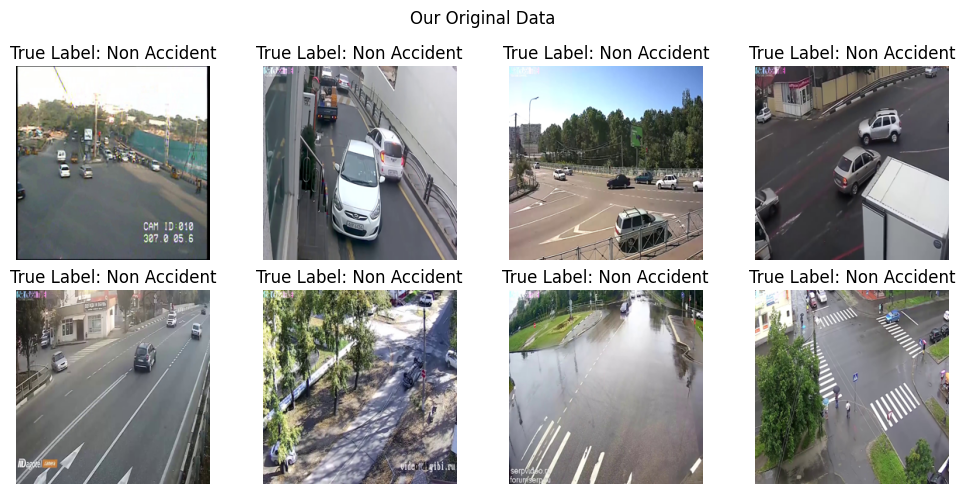

In [5]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
images = IMAGE_LIST_EXAMPLE
prediction = ["Non Accident"]
for i, ax in enumerate(axs.flat):
    filename = os.path.join(IMAGE_EXAMPLE_FOLDER_PATH,images[i])
    im = Image.open(filename).resize((250, 250))
    ax.imshow(im)
    ax.set_title(f"True Label: {prediction[0]}")
    ax.axis("off")
plt.suptitle("Our Original Data")
plt.tight_layout()
plt.show()

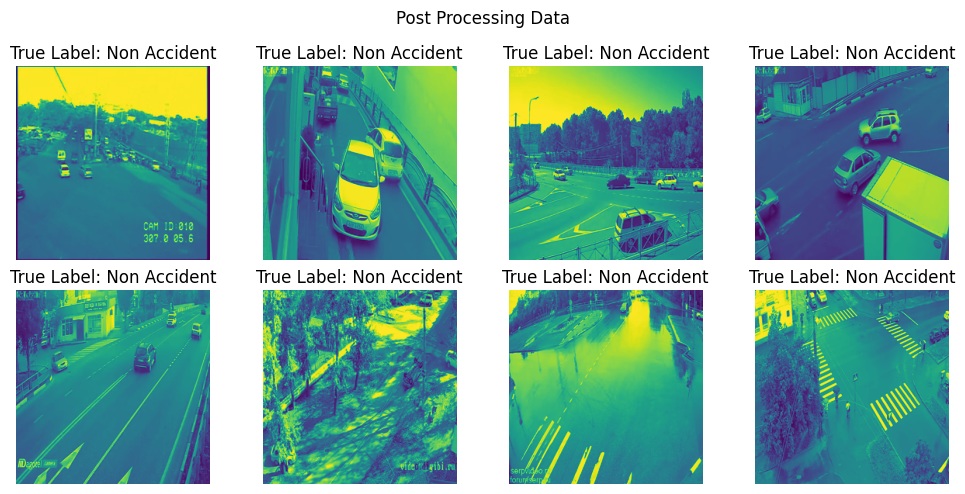

In [6]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
images = IMAGE_LIST_EXAMPLE
prediction = ["Non Accident"]
for i, ax in enumerate(axs.flat):
    filename = os.path.join(IMAGE_EXAMPLE_FOLDER_PATH,images[i])
    im = Image.open(filename).resize((img_height, img_width))
    im = im.convert('L')
    ax.imshow(im)
    ax.set_title(f"True Label: {prediction[0]}")
    ax.axis("off")
plt.suptitle("Post Processing Data")
plt.tight_layout()
plt.show()

In [5]:
datagen  = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

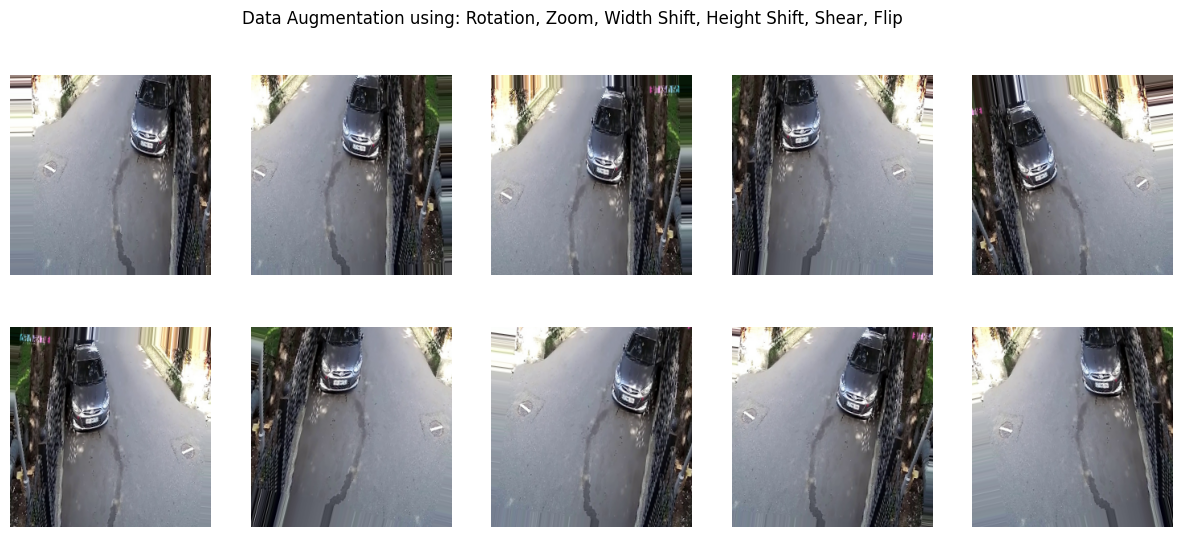

In [8]:
for input_tensor , label in testing_ds:
  img = np.expand_dims(input_tensor[0], axis=0)
  new_imgs = datagen.flow(img, batch_size=1) 
  fig, axs = plt.subplots(2, 5, figsize=(15, 6))
  axs = axs.flatten()
  for i, image in enumerate(new_imgs):
      if i >= 10: # Stop after generating 10 images
          break
      axs[i].imshow(image[0].astype('uint8'))
      axs[i].axis('off')
  plt.suptitle("Data Augmentation using: Rotation, Zoom, Width Shift, Height Shift, Shear, Flip")
  plt.show()

In [6]:
def generate_augmentation_data_set(data_set):
  img_tensor =tf.zeros(shape=0)
  label_tensor =tf.zeros(shape=0)
  for input_tensor , label in data_set:
    new_generated_data_set = input_tensor
    new_labels_data_set = label
    for j in range(input_tensor.shape[0]):
      img = np.expand_dims(input_tensor[j], axis=0)
      new_imgs = datagen.flow(img, batch_size=1) 
      for i, image in enumerate(new_imgs):
          if i >= 2: # Stop after generating 10 images
              break
          new_labels_data_set = tf.concat([new_labels_data_set, tf.expand_dims(label[j], axis=0)], axis=0)
          new_generated_data_set = tf.concat([new_generated_data_set, image], axis=0)
    if img_tensor.shape[0] == 0:
      img_tensor = new_generated_data_set
      label_tensor = new_labels_data_set
    else:
      label_tensor = tf.concat([new_labels_data_set, label_tensor], axis=0)
      img_tensor = tf.concat([new_generated_data_set, img_tensor], axis=0)
  # img_tensor = tf.expand_dims(img_tensor, axis=0)

  # label_tensor = tf.expand_dims(label_tensor, axis=0)
  new_testing_ds = tf.data.Dataset.from_tensor_slices((img_tensor, label_tensor)).batch(100)
  return new_testing_ds


In [7]:
testing_ds = generate_augmentation_data_set(testing_ds)
# training_ds = generate_augmentation_data_set(training_ds)
# validation_ds = generate_augmentation_data_set(validation_ds)


In [8]:
training_ds = training_ds.map(preprocess_image)
testing_ds = testing_ds.map(preprocess_image)
validation_ds = validation_ds.map(preprocess_image)

In [9]:
# Convert target labels to one-hot encoded format
training_ds = training_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
testing_ds = testing_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))
validation_ds = validation_ds.map(lambda x, y: (x, tf.one_hot(y, depth=2)))


# Model Architecture

In [13]:
input_shape = (250, 250, 1)

# Define model architecture
inputs = Input(shape=input_shape)
x = Conv2D(filters=8, kernel_size=(3,3), activation='relu')(inputs)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(filters=16, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)
x = MaxPool2D(pool_size=(2,2))(x)
x = Flatten()(x)
x = Dense(units=16, activation='relu')(x)
outputs = Dense(units=2, activation='softmax')(x)
model = Model(inputs=inputs, outputs=outputs) 

# model = tf.keras.models.Sequential([
#   tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(250, 250, 1)),
#   tf.keras.layers.MaxPooling2D((4, 4)),
#   tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#   tf.keras.layers.MaxPooling2D((4, 4)),
#   tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
#   tf.keras.layers.Conv2D(2, (1, 1), activation=None),
#   tf.keras.layers.GlobalAveragePooling2D()
# ])

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

#Model Size

In [11]:
def get_model_size(num_params):
    model_size_bytes = num_params
    model_size_kb = model_size_bytes / 1024
    model_size_mb = model_size_kb / 1024

    return {
        'bytes': f'{model_size_bytes} bytes',
        'kilobytes': f'{model_size_kb:.2f} KB',
        'megabytes': f'{model_size_mb:.2f} MB'
    }

# Print the number of parameters and the model size
num_params = model.count_params()
model_size = get_model_size(num_params)

model.summary()

print(f'Total number of parameters: {num_params}')
print(f'Model size: {model_size}')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 248, 248, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 15, 15, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 13, 13, 32)        18464     
                                                                 
 conv2d_3 (Conv2D)           (None, 13, 13, 2)         6

#Training Model

In [ ]:
for image, label in training_ds:
  print(image.shape)

In [14]:

# Compile model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
history = model.fit(training_ds, validation_data=validation_ds, epochs=NUM_OF_EPOCHS)



Epoch 1/50
8/8 [==============================] - 11s 441ms/step - loss: 0.6885 - accuracy: 0.5322 - val_loss: 0.6789 - val_accuracy: 0.5306
Epoch 2/50
8/8 [==============================] - 5s 156ms/step - loss: 0.6757 - accuracy: 0.5449 - val_loss: 0.6638 - val_accuracy: 0.5816
Epoch 3/50
8/8 [==============================] - 6s 255ms/step - loss: 0.6605 - accuracy: 0.5929 - val_loss: 0.6457 - val_accuracy: 0.6224
Epoch 4/50
8/8 [==============================] - 6s 161ms/step - loss: 0.6427 - accuracy: 0.6460 - val_loss: 0.6098 - val_accuracy: 0.7143
Epoch 5/50
8/8 [==============================] - 7s 155ms/step - loss: 0.6007 - accuracy: 0.6764 - val_loss: 0.5986 - val_accuracy: 0.6633
Epoch 6/50
8/8 [==============================] - 6s 262ms/step - loss: 0.5557 - accuracy: 0.7105 - val_loss: 0.5206 - val_accuracy: 0.7041
Epoch 7/50
8/8 [==============================] - 5s 166ms/step - loss: 0.5125 - accuracy: 0.7370 - val_loss: 0.4841 - val_accuracy: 0.7653
Epoch 8/50
8/8 [===

We'll let our model run for 50 epochs, which seems like a decent enough number. Increasing the epochs should result in an increase in accuracy uptil a certain point only though...

#Evaluate The Model on the test data

In [18]:
# Evaluate model
test_loss, test_acc = model.evaluate(testing_ds)

3/3 [==============================] - 0s 104ms/step - loss: 2.0740 - accuracy: 0.6600


# Plot The Results

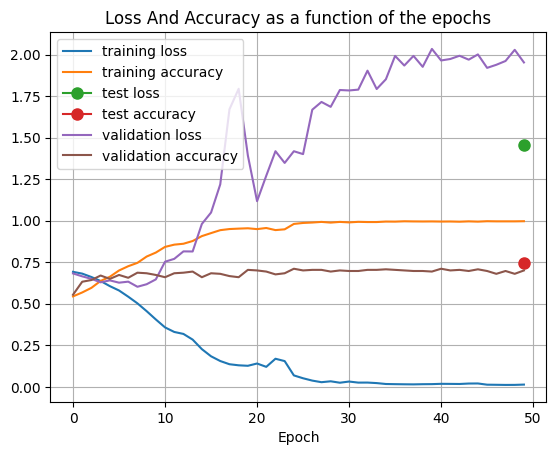

In [19]:

plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['accuracy'], label = 'training accuracy')
plt.plot(len(history.history['loss'])-1, test_loss, marker='o', markersize=8, label='test loss')
plt.plot(len(history.history['accuracy'])-1, test_acc, marker='o', markersize=8, label='test accuracy')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.plot(history.history['val_accuracy'], label = 'validation accuracy')
plt.grid(True)
plt.xlabel("Epoch")
plt.title("Loss And Accuracy as a function of the epochs")
plt.legend()

#Miscalssifications images

3/3 [==============================] - 1s 103ms/step


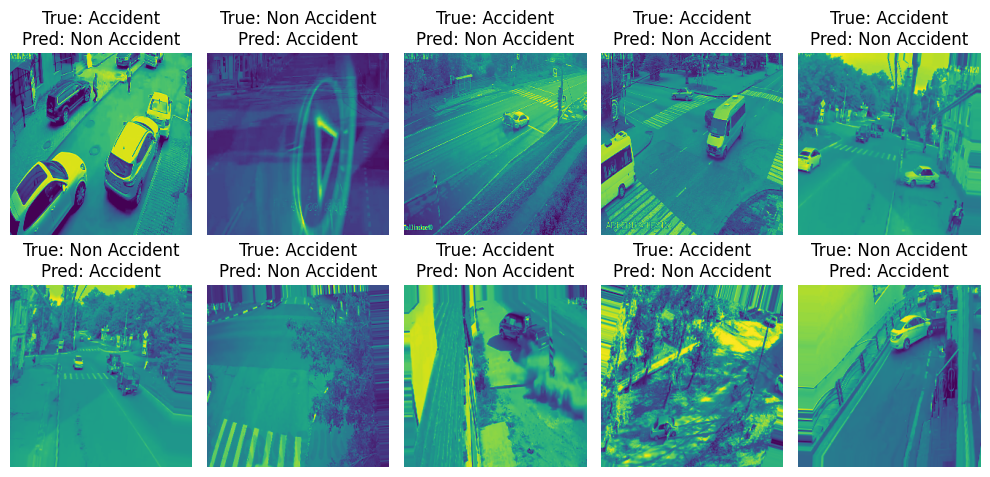

In [42]:
# Make predictions on the testing dataset
# testing_ds = testing_ds.unbatch()

y_pred = model.predict(testing_ds)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels from the testing dataset
y_true = np.concatenate([y for x, y in testing_ds], axis=0)
y_true_classes = np.argmax(y_true, axis=1)

# Find the misclassified images
misclassified_idxs = np.where(y_true_classes != y_pred_classes)[0]
j = 0
mis_imgs = []
mis_labels_true =[]
mis_labels_pred =[]
for images, labels in testing_ds:
  for i in range(10):
      idx = misclassified_idxs[i]
      if idx < (j+1) * batch_size:
        image = images[idx - j * batch_size].numpy()
        label_true = y_true_classes[idx]
        label_pred = y_pred_classes[idx]
        mis_imgs.append(image)
        mis_labels_true.append(label_true)
        mis_labels_pred.append(label_pred)

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5))

for ax, img, true_label, pred_label in zip(axes.flat, mis_imgs, mis_labels_true, mis_labels_pred):
    ax.imshow(img)
    ax.set_title("True: " + ["Accident","Non Accident"][true_label] + "\nPred: " + ["Accident","Non Accident"][pred_label])
    ax.axis('off')
plt.tight_layout()
plt.show()

# Converting to TFLite Model  
While we've made our model, it is true that Tensor Flow models are very large and bulky and not suitable for the small processing powers that a CCTV surveillance system will handle. For this purpose, we'll convert our Tf model into a TFLite model through the API's available by keras.

In [51]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('tf_lite_model.tflite', 'wb') as f:
    f.write(tflite_model)

In [52]:
interpreter = tf.lite.Interpreter(model_path = 'tf_lite_model.tflite')
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


While the steps below aren't necessary, I'll still show you incase you have to perform a similair task for a different model where the input tensor might change or be different.

In [54]:
interpreter.resize_tensor_input(input_details[0]['index'], (1, 250, 250,1))
interpreter.resize_tensor_input(output_details[0]['index'], (1, 2))
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print("Input Shape:", input_details[0]['shape'])
print("Input Type:", input_details[0]['dtype'])
print("Output Shape:", output_details[0]['shape'])
print("Output Type:", output_details[0]['dtype'])

Input Shape: [  1 250 250   1]
Input Type: <class 'numpy.float32'>
Output Shape: [1 2]
Output Type: <class 'numpy.float32'>


In [ ]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(10, 5))
images = ["5_10" , "test10_2", "test11_10", "test3_22", "test4_17", "test16_3", "test17_1", "test20_1"]
prediction = ["Non Accident"]
for i, ax in enumerate(axs.flat):
    filename = f"/content/drive/MyDrive/CarAccidentData/data/train/Non Accident/{images[i]}.jpg"
    im = Image.open(filename).resize((112, 112))
    im = im.convert('L')
    img_array = tf.keras.utils.img_to_array(im)
    img_batch = np.expand_dims(img_array, axis=0)
    interpreter.set_tensor(input_details[0]['index'], img_batch)
    interpreter.invoke()
    tflite_model_predictions = interpreter.get_tensor(output_details[0]['index'])
    ax.imshow(im)
    ax.set_title(f"Prediction: " + ["Accident","Non Accident"][np.argmax(tflite_model_predictions)])
    ax.axis("off")

plt.tight_layout()
plt.show()

# Trying Our TFLite Model Out  
We'll try our TFLite model on a random image and see what our output is and if it works. 

In [55]:
# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("car_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
# Indicate that we want to perform the default optimizations,
# which includes quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]
# Define a generator function that provides our test data's x values
# as a representative dataset, and tell the converter to use it
# def representative_dataset_generator():
#   for value in x_test:
#     # Each scalar value must be inside of a 2D array that is wrapped in a list
#     yield [np.array(value, dtype=np.float32, ndmin=2)]
# converter.representative_dataset = representative_dataset_generator
# Convert the model
tflite_model = converter.convert()

# Save the model to disk
open("car_accident_model_quantized.tflite", "wb").write(tflite_model)

204120

It works. We've got a complete end to end system for accident detection now that should work very well indeed.

In [56]:
import os
basic_model_size = os.path.getsize("sine_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("sine_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)

Basic model is 700672 bytes
Quantized model is 178336 bytes
Difference is 522336 bytes


In [57]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i car_accident_quantized.tflite > car_accident_model_quantized.cc
# Print the source file
!cat sine_model_quantized.cc

Streaming output truncated to the last 5000 lines.
  0xf8, 0x0f, 0xfd, 0xd6, 0xf6, 0xdf, 0xeb, 0x10, 0xe1, 0xed, 0xed, 0xee,
  0x20, 0xfc, 0xd8, 0xfb, 0xf1, 0x12, 0x07, 0x03, 0x1e, 0x0d, 0x09, 0xdc,
  0xe0, 0xdf, 0xef, 0x09, 0x0f, 0xf5, 0xf3, 0x02, 0xfe, 0x16, 0xe0, 0xd9,
  0xfc, 0xe3, 0xea, 0xe2, 0x1c, 0xda, 0x07, 0xdd, 0x14, 0x0c, 0x0d, 0x15,
  0xda, 0xe9, 0x0b, 0x19, 0x17, 0x12, 0xff, 0x0c, 0x0f, 0xf0, 0xdc, 0x0a,
  0x1c, 0x0c, 0xe8, 0x09, 0xfa, 0xe4, 0xf5, 0xf7, 0x15, 0xe8, 0xe0, 0x00,
  0xde, 0xdb, 0x03, 0x16, 0xf1, 0xf5, 0xe3, 0xfe, 0x02, 0xf7, 0x03, 0xe1,
  0x0c, 0xf4, 0xfb, 0x0e, 0xe1, 0x17, 0xf5, 0xf0, 0x17, 0xde, 0xff, 0xfd,
  0xe7, 0x11, 0xea, 0xde, 0xe6, 0x1b, 0xfa, 0xf1, 0x1f, 0xec, 0xde, 0xdf,
  0xfd, 0xf8, 0xfd, 0x17, 0xed, 0x0a, 0x13, 0x03, 0x02, 0x05, 0xef, 0xd7,
  0xe1, 0xe0, 0xe8, 0x16, 0x20, 0x0b, 0xde, 0xd6, 0xdf, 0xf4, 0x16, 0xdb,
  0xf5, 0xe4, 0xd9, 0x0f, 0x04, 0xed, 0xd7, 0x08, 0x13, 0xd6, 0xd6, 0xf7,
  0xff, 0x04, 0xf6, 0xfd, 0x12, 0x0f, 0x18, 0x0e, 0xf0, 0xda,